In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import scipy as scp
import sklearn as skl

In [2]:
#!pip install opencv-python==4.2.0.34
#!pip install imgaug

In [3]:
import imgaug.augmenters as iaa

In [4]:
import matplotlib.pyplot as plt

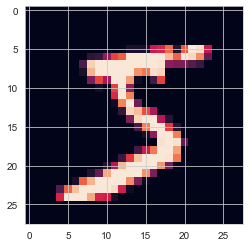

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
plt.imshow(x_train[0])
#x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
#x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

In [6]:
np.concatenate([x_test[0].reshape(28,28,1),x_test[0].reshape(28,28,1),x_test[0].reshape(28,28,1)],axis = 2).shape

(28, 28, 3)

In [7]:
aug = iaa.Grayscale(alpha=(0.0, 1.0))
def def_augment(n=3, m=7):
    #
    rand_aug = iaa.RandAugment(n=n, m=m)
    #     @tf.numpy_function
    def augment(images):
        # Input to `augment()` is a TensorFlow tensor which
        # is not supported by `imgaug`. This is why we first
        # convert it to its `numpy` variant.
        print(images.shape)
        images = aug(images=images)
        return rand_aug(images=images).reshape(-1,784)
    return augment

In [8]:
#aug_bis = def_augment()

In [9]:
#x_color = x_test.reshape(-1,28,28,1)
#x_color = np.concatenate([x_color,x_color,x_color],axis = 3)
#a = aug_bis(images = x_color)

In [10]:
batch_size = 100 # the number of repetition * batch_size must be <= to the dataset size
nb_classes = 10
#def data_loader_custom(X,augmentation_1 = lambda x : x ,augmentation_2 = lambda x : x, nb_classes = nb_classes):
def data_loader_custom(X,augmentation_1 = def_augment(n=2, m=21) ,augmentation_2 = def_augment(n=3, m=12), nb_classes = nb_classes):

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=2*batch_size)
        ds = ds.batch(batch_size=batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
    
    X_color = X.reshape(-1,28,28,1)
    X_color = np.concatenate([X_color,X_color,X_color],axis = 3)
    print("FIRST PART")
    X_aug1 = augmentation_1(X_color)
    print("SECOND PART")
    X_aug2 = augmentation_2(X_color)
    #print("THIRD PART")
    #y = tf.constant(np.random.randint(0,2,size=(len(X_aug1),nb_classes)))

    #fake_labels = tf.data.Dataset.from_tensor_slices(y)
    ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_aug1), tf.data.Dataset.from_tensor_slices(X_aug2)))
    #X = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_aug1), tf.data.Dataset.from_tensor_slices(X_aug2)))
    #print("JUNCTION")
    #ds = tf.data.Dataset.zip((X,fake_labels))
    ds = configure_for_performance(ds)
    return ds

In [11]:
X_train = data_loader_custom(x_train)
X_test =  data_loader_custom(x_test)

FIRST PART
(60000, 28, 28, 3)
SECOND PART
(60000, 28, 28, 3)
FIRST PART
(10000, 28, 28, 3)
SECOND PART
(10000, 28, 28, 3)


In [12]:
X_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 784), dtype=tf.uint8, name=None))>

In [13]:
x_test.shape[0]%batch_size 

0

In [14]:
x_train.shape[0]%batch_size 

0

In [15]:
avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

def tf_unif_prior_crossentropy(pred1,pred2):
        N = batch_size
        C = nb_classes
        t_c = 0.1
        t_r = 0.1
        a = tf.nn.softmax(pred2/t_c, axis=0)
        b = tf.linalg.norm(a, ord=1,axis=1)
        try :
            c = a/tf.reshape(b,(N,-1))
        except :
            try :
                c = a/tf.reshape(b,(x_train.shape[0]%batch_size,-1))
            except :
                c = a/tf.reshape(b,(x_test.shape[0]%batch_size,-1))
                

        part11 = c
        d = tf.nn.softmax(pred1/t_r, axis=1)
        part21 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)), (-1,C))
        loss_1 = -tf.math.reduce_sum( part11 * part21 , axis=-1)


        a = tf.nn.softmax(pred1/t_c)
        b = tf.linalg.norm(a, ord=1,axis=1)
        c = a/tf.reshape(b,(N,-1))
        part12 = c
        d = tf.nn.softmax(pred2/t_r, axis=1)
        part22 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)),(-1,C))
        loss_2 = -tf.math.reduce_sum( part12*part22 , axis=-1)

        return tf.math.reduce_mean(1/2*(loss_1+loss_2))

class custom_fit(tf.keras.Model):
    
    
    
    def train_step(self, data):
        input_data = data
        with tf.GradientTape() as tape:
            outputs = self(input_data, training=True) # forward pass 
            pred1 = outputs[0]
            pred2 = outputs[1]
            total_loss = tf_unif_prior_crossentropy(pred1,pred2)
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        avg_loss.update_state(total_loss)
        return {"loss": avg_loss.result()}
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [avg_loss]

In [16]:
def create_model_aux(dropout = 0.5):
    
    input_layer = tf.keras.layers.Input(shape=(28*28), dtype=tf.float32)

    first_layer = tf.keras.layers.Dense(512, activation = "selu")(input_layer)
#     first_layer = tf.keras.layers.Dropout(dropout)(first_layer)
    first_layer = tf.keras.layers.BatchNormalization()(first_layer)
    first_layer = tf.keras.layers.Dense(256, activation = "selu")(first_layer)
#     first_layer = tf.keras.layers.Dropout(dropout)(first_layer)
    first_layer = tf.keras.layers.BatchNormalization()(first_layer)
    first_layer = tf.keras.layers.Dense(128, activation = "selu")(first_layer)
#     first_layer = tf.keras.layers.Dropout(dropout)(first_layer)
    first_layer = tf.keras.layers.BatchNormalization()(first_layer)

    output = tf.keras.layers.Dense(nb_classes,activation = None, dtype='float32')(first_layer)
#     output = tf.keras.layers.Dropout(dropout)(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Activation("softmax")(output)
    model = tf.keras.models.Model(inputs=input_layer, outputs= output)
    return model

def create_model():
    model_shared = create_model_aux()
    input_x1 = tf.keras.layers.Input(shape=(28*28), dtype=tf.float32)
    input_x2 = tf.keras.layers.Input(shape=(28*28), dtype=tf.float32)
    output_x1 = model_shared(input_x1)
    output_x2 = model_shared(input_x2)
#     output = tf.keras.layers.Average()([output_x1, output_x2])
#     model = tf.keras.models.Model(inputs=[input_x1,input_x2], outputs = output)
    model = custom_fit(inputs=[input_x1,input_x2], outputs = [output_x1,output_x2])
    model.compile(loss=tf_unif_prior_crossentropy,metrics=[],optimizer = "Adam")
    return model

In [17]:
test_model = create_model()

In [18]:
lr_min = 1e-5
lr_max = 1e-2
import os
def my_cosine_decay(epoch,
                    epoch_max=5,
                    LR_START = 0.0001/2,
                    LR_MAX =  lr_max,
                    LR_MIN = lr_min,
                    LR_RAMPUP_EPOCHS = 3,
                    LR_SUSTAIN_EPOCHS = 0,
                    LR_ALPHA_DECAY = .7
                   ):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        cosine_decay=max(0.5*(1+np.cos(np.pi*((epoch-LR_RAMPUP_EPOCHS)/epoch_max))),LR_MIN)
        decayed=(1-LR_ALPHA_DECAY)*cosine_decay+LR_ALPHA_DECAY
        learning_rate=LR_MAX*decayed
    return learning_rate

def lr_decay(epoch,
            LR_START = lr_max/2,
            LR_MAX =  lr_max,
            LR_MIN = lr_min,
            LR_RAMPUP_EPOCHS = 3,
            LR_SUSTAIN_EPOCHS = 0,
            LR_ALPHA_DECAY = .05
                   ):
    learning_rate=max(LR_MAX*np.exp(-LR_ALPHA_DECAY*epoch), LR_MIN)
    return learning_rate
   

def my_clr(epoch,
           epoch_cycle = 4,
           LR_MIN = lr_min,
           LR_MAX = lr_max,
           LR_ALPHA_DECAY = .9):
    nb_cycle = epoch // epoch_cycle
    k=0
    while k < nb_cycle :
        LR_MAX = (LR_MAX+ LR_MIN)*LR_ALPHA_DECAY
        k += 1
    if epoch % epoch_cycle < epoch_cycle//2 :
        learning_rate = (LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MIN
    else :
        learning_rate = -(LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MAX
    return learning_rate
    
lrfn=lambda epoch : my_clr(
       epoch,
        LR_MIN = lr_min,
        LR_MAX = lr_max
    )

checkpoint_filepath = r"C:\Users\bapti\KTH\mnist\checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_best_only=True)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=16,verbose=1)

In [19]:
history = test_model.fit(x =X_train,epochs = 1000, steps_per_epoch = int(len(x_train)/batch_size),callbacks = [lr_callback, early_stopper])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/1000
600/600 [==============================] - 15s 22ms/step - loss: 2.5059 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.005005.
Epoch 2/1000
600/600 [==============================] - 13s 22ms/step - loss: 1.9342 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/1000
600/600 [==============================] - 12s 20ms/step - loss: 1.6831 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.005005.
Epoch 4/1000
600/600 [==============================] - 12s 20ms/step - loss: 1.5393 - lr: 0.0050

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/1000
600/600 [==============================] - 12s 20ms/step - loss: 1.5032 - lr: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 0.0045095.
Epoch 6/1000
600/600 [==============================] - 12s 21ms/step - loss: 1.5127 - lr: 0.0045

Epoch 7: L

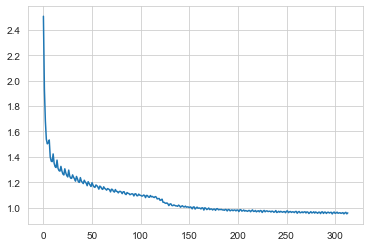

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])

In [23]:
results = test_model.predict([x_test.reshape(-1,784),x_test.reshape(-1,784),])

In [24]:
y_predict_labels = (results[0][:]+results[1][:]).argmax(axis = 1)

In [25]:
y_predict_labels

array([5, 9, 5, ..., 6, 5, 9], dtype=int64)

In [26]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [27]:
nb_unique_values = dict.fromkeys(np.unique(y_test),0)
for i in range(len(y_test)):
    nb_unique_values[y_test[i]] += 1

In [28]:
nb_unique_values

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

In [29]:
pred_nb_unique_values = dict.fromkeys(np.unique(y_predict_labels),0)
for i in range(len(y_predict_labels)):
    pred_nb_unique_values[y_predict_labels[i]] += 1

In [30]:
pred_nb_unique_values

{0: 50, 3: 2640, 4: 332, 5: 2490, 6: 1083, 8: 1155, 9: 2250}

In [31]:
def class_ajustement(true, preds):
    res_mat = np.zeros((len(np.unique(true)),len(np.unique(preds))))
    for i in range(true.shape[0]):
        res_mat[true[i],preds[i]] += 1
    return res_mat

In [ ]:
y_test.shape

In [32]:
res_mat = class_ajustement(y_test,y_predict_labels)

IndexError: index 9 is out of bounds for axis 1 with size 7

In [ ]:
res_mat

In [ ]:
np.max(res_mat)

In [ ]:
import seaborn as sns
sns.set()
plt.figure(figsize=(16, 16))
ax = sns.heatmap(res_mat/np.max(res_mat), vmin=0, vmax=1)
plt.show()

In [ ]:
assignees = [False for i in range(nb_classes)]
np.argsort(res_mat[:])

In [ ]:
res_mat[:]

In [ ]:
np.flip(res_mat[:][0])

In [ ]:
for i in range(10):
    print("for class ",i," best match is ",np.flip(np.argsort(res_mat[:][i])), "with confidence ",res_mat[:][i][np.flip(np.argsort(res_mat[:][i]))]/res_mat[i].sum())